# APPJ_Dynamic_Modeling_GP

* Written by: Angelo D. Bonzanini and Ketong Shao
* Date: August 2021

<< Code Desctription >>

## Imports

In [4]:
# General
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
execution_path = '/content/gdrive/MyDrive/Colab Notebooks/Code/ML-for-plasmas'

Mounted at /content/gdrive


## Define parameters class

In [5]:
class Parameters():
  def __init__(self):
    self.lag = 3

# Instantiate object
p = Parameters()
print(p.lag)

3


## Raw data

In [6]:
# Load raw data
print('Column Headers:')
print('(1) time,(2) Tset,(3) Ts,(4) Ts2,(5) Ts3, (6) P, (7) Imax, (8) Ip2p, \n (9) O777, (10) O845, (11) N391, (12) He706, (13) sum_int, \n (14, 15, 16, 17) *U_m --> (V, freq, q, dsep), (18) q_o, (19) D_c, (20) x_pos, \n (21) y_pos, (22) T_emb, (23) Pset, (24) P_emb, (25) Prms, \n (26) Rdel, (27) Is, (28, 29) sig --> (1 and 2), (30) subs_type, (31) Trot, \n (32) tm_el')
print('\nWARNING: Some of the headers (e.g., *U_m) contain more than one entries, which creates a mismatch between the column headers and the values.\n Therefore, we discard the headers and re-load the file starting from the first row')

data = pd.read_csv(execution_path+'/../Data/APPJ_step_input_tests_glass_and_metal.csv', skiprows=[0], header=None)
print('\nData shape after discarding row = [0]: ', data.shape)


Column Headers:
(1) time,(2) Tset,(3) Ts,(4) Ts2,(5) Ts3, (6) P, (7) Imax, (8) Ip2p, 
 (9) O777, (10) O845, (11) N391, (12) He706, (13) sum_int, 
 (14, 15, 16, 17) *U_m --> (V, freq, q, dsep), (18) q_o, (19) D_c, (20) x_pos, 
 (21) y_pos, (22) T_emb, (23) Pset, (24) P_emb, (25) Prms, 
 (26) Rdel, (27) Is, (28, 29) sig --> (1 and 2), (30) subs_type, (31) Trot, 
 (32) tm_el

 Therefore, we discard the headers and re-load the file starting from the first row

Data shape after discarding row = [0]:  (6592, 32)


## Data Pre-processing

We seek to construct a multi-input-multi-output (MIMO) dynamic model of the form
\begin{align}
x_{k+1} = g(x_k, u_k),
\end{align}
where $x = (\text{Temperature}, \text{Intensity})$, $u = (\text{Applied Power}, \text{Helium Flowrate})$, and $g(\cdot)$ is a nonlinear function that is learned from the data and aims to correct for the plant-model mismatch.

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


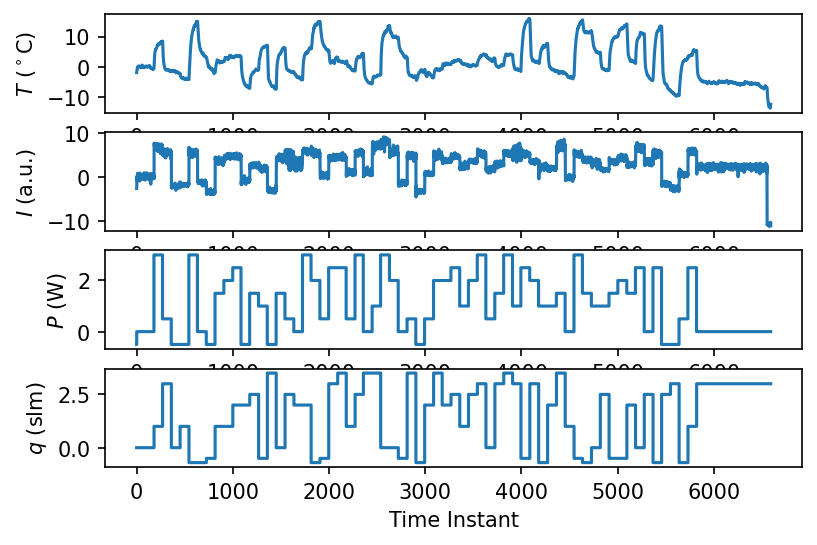

In [7]:
# Extract quantities of interest
xData = data.iloc[:, [2, 12]]
uData = data.iloc[:, [22, 15]]

# Convert to deviation variables
xss = xData.iloc[5:25, :].mean(axis=0)
uss = uData.iloc[5:25, :].mean(axis=0)

xData.iloc[:,0] = xData.iloc[:,0] - xss.iloc[0]
xData.iloc[:,1] =20*(xData.iloc[:,1] - xss.iloc[1])/xData.iloc[:,1].max()
uData = uData - uss

# Plot time-series data
plt.figure(dpi=150)
plt.subplot(411)
plt.plot(range(0, len(xData.iloc[:,0])), xData.iloc[:,0])
plt.ylabel('$T \ (^\circ$C)')
plt.subplot(412)
plt.plot(range(0, len(xData.iloc[:,1])), xData.iloc[:,1])
plt.ylabel('$I$ (a.u.)')
plt.subplot(413)
plt.step(range(0, len(uData.iloc[:,0])), uData.iloc[:,0])
plt.ylabel('$P$ (W)')
plt.subplot(414)
plt.step(range(0, len(uData.iloc[:,1])), uData.iloc[:,1])
plt.ylabel('$q$ (slm)')
plt.xlabel('Time Instant')
plt.show()

In [8]:
# Discard the last part of the time-series data
p.kStart = 5
p.kEnd = 6100
xData = xData.iloc[p.kStart:p.kEnd, :]
uData = uData.iloc[p.kStart:p.kEnd, :]

# Save the relevant dimensions
p.nx = xData.shape[1]
p.nu = uData.shape[1]

Next, we want to re-structure the above dataset such that the states and inputs from time instant $k-\ell$ up to $k-1$ are used to predict the states at time instant $k$. That is,
\begin{align}
x_k = g(x_{k-\ell}, \ldots, x_{k-1},u_{k-\ell}, \ldots, u_{k-1}),
\end{align}
where $\ell$ is a user-defined lag and $\Delta x_k = x_{k+1} - (Ax_k+Bu_k)$.

Therefore, the inputs $\mathcal{D}_X$ and outputs $\mathcal{D}_Y$ are
\begin{align}
\mathcal{D}_X =
\begin{bmatrix}
x_{0}^\top & \ldots & x_{\ell-1}^\top & u_{0}^\top & \ldots & u_{\ell-1}^\top  
\\
x_{1}^\top &\ldots & x_{\ell}^\top & u_{1}^\top &\ldots & u_{\ell}^\top
\\
\vdots & \ddots & \vdots & \vdots & \ddots & \vdots
\\
x_{k-\ell}^\top &  \ldots & x_{k-1}^\top & u_{k-\ell}^\top &  \ldots & u_{k-1}^\top
\end{bmatrix}
\quad
\mathcal{D}_Y = 
\begin{bmatrix}
 x_{\ell}^\top
\\
 x_{\ell+1}^\top
\\
\vdots
\\
 x_{k}^\top
\end{bmatrix}
\end{align}

In [9]:
p.Nsamp = xData.shape[0] - p.lag
Dx = np.zeros((p.Nsamp, p.lag*(p.nx+p.nu)))
Dy = np.zeros((p.Nsamp, p.nx))

counter = 0
for k in range(0, p.Nsamp):
  # Input data
  Dx[k, 0:p.nx*p.lag] = np.concatenate((xData.iloc[k:k+p.lag, 0], xData.iloc[k:k+p.lag, 1]))
  Dx[k, p.nx*p.lag:] =  np.concatenate((uData.iloc[k:k+p.lag, 0], uData.iloc[k:k+p.lag, 1]))
  # Output data
  Dy[k, :] = np.array([xData.iloc[k+p.lag, 0], xData.iloc[k+p.lag, 1]])

In [10]:
# Split into training and test data using sklearn
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(Dx, Dy, test_size=0.2, random_state=0)

Ntrain = xTrain.shape[0]
Ntest = xTest.shape[0]
print('Ntrain = ', Ntrain)
print('Ntest  = ', Ntest)

Ntrain =  4873
Ntest  =  1219


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import GridSearchCV


# Function to create GPR model
def create_model(constant_value = 1, length_scale = 0.5, alpha = 0):
  kernel = ConstantKernel(constant_value=constant_value, constant_value_bounds="fixed") * RBF(length_scale=length_scale, length_scale_bounds="fixed")
  model = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=alpha)
  return model

model = create_model()
# model.get_params().keys() # Run this to see how to define the hyperparameters in the dictionary below

# Define the grid search parameters
length_scale = [1, 5, 10, 12, 15, 17, 20]
constant_value = [0.1, 0.5, 0.75, 1, 2, 5, 10]
alpha = [0, 0.001, 0.01]
np.random.seed(0)
param_grid = dict(alpha=alpha,
                  kernel__k1__constant_value = constant_value,
                  kernel__k2__length_scale=length_scale)

# Run the grid-serach algorithm
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid1 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid2 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)


grid_result = grid.fit(xTrain, yTrain)
grid_result1 = grid1.fit(xTrain, yTrain[:,0])
grid_result2 = grid2.fit(xTrain, yTrain[:,1])

# Print best combination of hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result1.best_params_))
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))

Best: 0.992589 using {'alpha': 0.001, 'kernel__k1__constant_value': 0.75, 'kernel__k2__length_scale': 20}
Best: 0.999817 using {'alpha': 0.001, 'kernel__k1__constant_value': 0.75, 'kernel__k2__length_scale': 20}
Best: 0.965193 using {'alpha': 0.001, 'kernel__k1__constant_value': 0.5, 'kernel__k2__length_scale': 10}


In [ ]:
yPred = grid_result.predict(xTest)
yPred1 = grid_result1.predict(xTest)
yPred2 = grid_result2.predict(xTest)

hyperparameters = grid_result.best_params_
tunedModel = model(constant_value = hyperparameters['kernel__k1__constant_value'], 
                   length_scale = hyperparameters['kernel__k2__length_scale'], 
                   alpha = hyperparameters['alpha'])
gpr = tunedModel.fit(xTrain, yTrain)

yPredGPR = gpr.predict(xTest)

plt.figure(dpi=150, figsize=(10, 6))
plt.subplot(121)
plt.plot(yTest[:,0], yTest[:,0], 'g-', lw=2, label = 'Predicted = Test')
plt.plot(yTest[:,0], yPred[:,0], 'r.', ms=1, label = 'Predicted')
plt.plot(yTest[:,0], yPred1, 'b.', ms=1, label = 'Predicted (individual)')
plt.plot(yTest[:,0], yPredGPR[:,0], 'm.', ms=1)
plt.legend()
plt.ylabel('Test')
plt.xlabel('Predicted')
plt.title('$T-T^{ss}$')
#
plt.subplot(122)
plt.plot(yTest[:,1], yTest[:,1], 'g-', lw=2, label = 'Predicted = Test')
plt.plot(yTest[:,1], yPred[:,1], 'r.', ms=1, label = 'Predicted')
plt.plot(yTest[:,1], yPred2, 'b.', ms=1, label = 'Predicted (individual)')
plt.legend()
plt.xlabel('Test')
plt.title('$I-I^{ss}$')
plt.show()

# Quantify R2 score
from sklearn.metrics import r2_score

print('\n---------- R2 scores ----------')
gpR2 = r2_score(yTest, yPred, multioutput = 'raw_values')
print(gpR2)



TypeError: ignored

In [ ]:
plt.figure(dpi=150, figsize = (5, 3))
plt.plot(yTest[100:150, 0], 'g')
plt.plot(yPred[100:150,0], 'r--')
plt.show()

# To Do
* Unshuffle the data and use the GP model to make predictions for some relatively shorter time horizon
* Show uncertainty bounds